# Classification Metrics:


![target image](https://github.com/ninja-josh/image-storage/raw/main/qft5tas90c801%20(1).jpeg)

## How do we know if our model is any good?


## Regression vs Classification Metrics

### Regression Metrics

In a regression model a target label could have any value (theoretically).

When we are creating a regression model, we try to create a model that predicts a label that is as close to the true label value for a sample as possible.  This is why we use metrics like mean absolute error, mean squared error, or root mean squared error.  We want to know how far away the prediction from the truth.  In fact, our model may never make a perfectly accurate prediction and that's fine, as long as it is close enough.

### Classification Metrics

With classification models each sample is a member of one of a finite number of classes.  For each sample, either the model predicts the correct class or predicts one of the incorrect classes.  It's right or wrong, there is no 'close'.

Because of this we need different metrics.  In this lesson we will explore how to evaluate a classification model using:

1. Accuracy
2. Precision
3. Recall
4. A Confusion Matrix

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import seaborn to make a nice heatmap for our confusion matrix
import seaborn as sns

#import some necessary tools
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer

#import accuracy, precision, recall, classification report, and confusion matrix scoring functions
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#Importing the KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

'Breast Cancer Wisconsin' is a binary classification dataset that comes with the sklearn package in order to demonstrate and experiment with models.  We will use this well studied and pre-cleaned dataset to demonstrate how to evaluate a classification model on a binary classification problem.  Each record in this dataset is a mass in a breast and each feature is a measurement of that mass.  The target is 0 = benign, or 1 = malignant.

Our task will be to create a model that classifies a given mass as either benign or malignant.  

In [204]:
#Load the Data
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns = data.feature_names)
X['outcome'] = pd.DataFrame(data.target, columns=['outcome'])
y = X['outcome']
X.drop(columns=['outcome'])
#y = pd.DataFrame(data.target, columns=['outcome'])
print(y.value_counts(normalize=True))
X.head()

1    0.627417
0    0.372583
Name: outcome, dtype: float64


mean radius  mean texture  ...  worst fractal dimension  outcome
0        17.99         10.38  ...                  0.11890        0
1        20.57         17.77  ...                  0.08902        0
2        19.69         21.25  ...                  0.08758        0
3        11.42         20.38  ...                  0.17300        0
4        20.29         14.34  ...                  0.07678        0

[5 rows x 31 columns]

In [205]:
#Prepare the data for modeling and validation
#Train-test split.  Set the random state to 42
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)


# Baseline vs KNN

In [206]:
def calculate_model(X_train, X_test, y_train, y_test, reg_type, my_title, gen_cm=False, my_color = 'Blues',normVal=None):
    
    #Create a pipeline with a StandardScaler and a KNeighborsClassifier
    #Create another pipeline with StandardScaler and DummyClassifier
    #using the 'most_frequent' strategy
    num_selector = make_column_selector(dtype_include="number")
    scaler = StandardScaler()
    scaler_tuple = (scaler, num_selector)
    #Fit both model pipelines and save their predictions test sets

    #Instantiating the column transformer
    column_transformer = make_column_transformer(scaler_tuple)

    my_dict = dict()

    pipe = make_pipeline(column_transformer, reg_type)
    pipe.fit(X_train, y_train)
    score = pipe.score(X_test, y_test)
    my_dict['score'] = score
    if gen_cm == True:
        predictions = pipe.predict(X_test)
        my_confusion_matrix = metrics.confusion_matrix(y_test, predictions)
        my_class_report = metrics.classification_report(y_test, predictions,zero_division=1)
        my_dict['my_class_report'] = my_class_report
        my_dict['true_neg'], my_dict['false_pos'], my_dict['false_neg'], my_dict['true_pos'] = my_confusion_matrix.ravel()
        disp = ConfusionMatrixDisplay.from_predictions(y_test, predictions, cmap = my_color,normalize=normVal);
        disp.ax_.set_title(my_title)
        plt.show()
    return my_dict

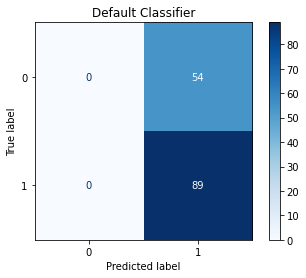

Confusion Matrix with score:0.6224, True Negative:0, False Positive: 54, False Negative: 0, True Positive: 89


In [207]:
my_classifier = DummyClassifier()
m_title = 'Default Classifier'
dy_mets = calculate_model(X_train, X_test, y_train, y_test, my_classifier, m_title, True)
print("Confusion Matrix with score:{0:,.4f}, True Negative:{1:,.0f}, False Positive: {2:,.0f}, False Negative: {3:,.0f}, True Positive: {4:,.0f}"\
      .format(dy_mets['score'],dy_mets['true_neg'],dy_mets['false_pos'],dy_mets['false_neg'],dy_mets['true_pos']))


In [208]:
#This section helps to determine K that provides optimal accuracy
max_knn_score = 0
counter = 1
for n in range(1,100):     #Setting the upper limit of the range to obtain a higher accuracy
    my_classifier = KNeighborsClassifier(n_neighbors=n,)
    m_title = str(n) + "Nearest Neighbor Classifier"
    temp = calculate_model(X_train, X_test, y_train, y_test, my_classifier, m_title,False);
    if temp['score'] > max_knn_score :
        max_knn_score = temp['score']
        max_knn_counter = counter + 1
    counter += 1

Quickly remind yourself of what you learned about type 1 and type 2 errors.  In every binary classification problem we select one class to be the **'positive'** class and one to be the **'negative'** class.  The positive class should be the one you are most interested in finding.  For our breast cancer dataset the positive class will be the malignant masses and the negative class will be the benign one.

## Type 1 error:
If our model predicts that a mass is malignant, but it is in fact benign, it will have made a type 1 error.  This is also known as a false positive

## Type 2 error:
If our model predicts that a mass is benign, when in fact it is malignant, it will have made a type 2 error.  This is is also known as a false negative.


*Which of these do you think is worse in this case?  If we have to increase one kind of error in order to minimize the other kind, which would we want to minimize?  Why?*

# Accuracy

Accuracy is the metric that is most intuitive.  This is defined as:

$$
accuracy = \frac{True  Positives + True  Negatives}{All  Samples}
$$

In other words accuracy is correct predictions our model made out of the total number of predictions.

Pros:
Accuracy is easy to understand and gives a combined picture of both kinds of errors in one number.

Cons: Accuracy can be deceiving when a dataset is unbalanced.  It also does not give specific information about the kinds of errors that a model is making.

For example, we saw above that 62% of our samples are malign masses when we did `y.value_counts(normalize=True)`

To use the sklearn metrics functions we pass them first the true labels, then the predicted labels.  For example: `accuracy = accuracy_score(y_test, y_pred)`

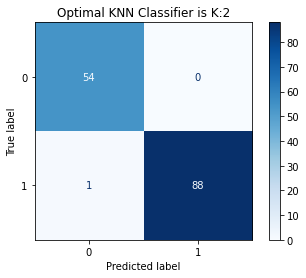

Confusion Matrix with score:0.9930, True Negative:54, False Positive: 0, False Negative: 1, True Positive: 88


In [209]:
#Print the accuracy of both models on the test set
my_classifier = KNeighborsClassifier(n_neighbors=max_knn_counter)
m_title = "Optimal KNN Classifier is K:" + str(max_knn_counter)
kn_mets = calculate_model(X_train, X_test, y_train, y_test, my_classifier, m_title, True)
print("Confusion Matrix with score:{0:,.4f}, True Negative:{1:,.0f}, False Positive: {2:,.0f}, False Negative: {3:,.0f}, True Positive: {4:,.0f}"\
      .format(kn_mets['score'],kn_mets['true_neg'],kn_mets['false_pos'],kn_mets['false_neg'],kn_mets['true_pos']))


If our dataset were even more imbalanced, say 99.9% malignant, then a prediction that EVERYTHING is malignant would have a very high accuracy.  However, that would not be a very useful model for actual medical use.  More often we see the opposite: a disease is very rare, occurring .01% of the time or less, and a model that predicts that NO samples ever have the disease will have a high accuracy, but will actually be useless...and dangerous!

# Recall

When we want to reduce the number of false negatives, we want to improve recall.

Recall is defined as: 

$$
recall = \frac{True Positives}{False Negatives + True Positives}
$$

That is to say: how many samples did our model label as positive out of all of the true positive samples?

Pros: A higher recall means a fewer false negative predictions, also known as type 2 errors.  It's great for when classifying a positive as a negative is a costly mistake.

Cons: Does not consider how many samples are falsely labeled as positive, or false positives.  It does not penalize type 1 errors.

In the case of this dataset, we might assume that the consequence for a false negative is that a person needlessly dies from cancer while the consequence for a false positive is that someone has unnecessary surgery.  While neither is great, the second is generally going to be less bad.  A high recall means fewer malignant masses going untreated.

In [210]:
#Print the recall scores of both models.
#dy_mets is the dicitonary containing the dummy confusion matrics values
#knn_mets is the dictionary containing the KNN Optimal matrics values
print("Default Classifier recall score is: {:,.4f}".format(dy_mets['true_pos']/(dy_mets['false_neg']+dy_mets['true_pos'])))
print("KNN Classifier recall score is: {:,.4f}".format(kn_mets['true_pos']/(kn_mets['false_neg']+kn_mets['true_pos'])))

Default Classifier recall score is: 1.0000
KNN Classifier recall score is: 0.9888



You can see that our KNN model has a high recall, but just predicting that ALL tumors are malignant gives us a perfect recall of 1!  While we want to catch as many malignant tumors as possible, we don't want to just send everyone under the knife, especially since we know that 38% don't need surgery!

# Precision

When we want to reduce the number of false positives, we want to improve precision.

Precision is defined as:

$$
precision = \frac{True Positives}{False Positives + True Positives}
$$

In other words: What ratio of the samples that we predicted were in the positive class were actually in the positive class?

Pros:  A high precision means fewer type 1 errors, or fewer false positives.  This is a good metric to maximize if a false positive prediction is a costly mistake.

Cons: Precision does not penalize a model for false negatives.  It does not count type 2 errors.

In this case precision would be measuring how many of the tumors we elected to operate on were actually malignant.

In [211]:
#Print the precision scores of both models.
print("Default Classifier precision score is: {:,.4f}".format(dy_mets['true_pos']/(dy_mets['false_pos']+dy_mets['true_pos'])))
print("KNN Classifier precision score is: {:,.4f}".format(kn_mets['true_pos']/(kn_mets['false_pos']+kn_mets['true_pos'])))

Default Classifier precision score is: 0.6224
KNN Classifier precision score is: 1.0000


# The Complete Picture: Confusion Matrices and classification_report()

As you have seen, precision, precision, and recall each only tell part of the story.  In order to get the full picture of how your model is performing and what kinds of mistakes it tends to make, you need to look at a confusion matrix and/or sklearn's handy `classification_report()` function.

In [212]:
#Use confusion_matrix() to print confusion matrices for both models
print("Default Classifier Confusion Matrix; True Negative:{:,.0f}, False Positive: {:,.0f}, False Negative: {:,.0f}, True Positive: {:,.0f}"\
      .format(dy_mets['true_neg'],dy_mets['false_pos'],dy_mets['false_neg'],dy_mets['true_pos']))

print("KNN Classifier Confusion Matrix; True Negative:{:,.0f}, False Positive: {:,.0f}, False Negative: {:,.0f}, True Positive: {:,.0f}"\
      .format(kn_mets['true_neg'],kn_mets['false_pos'],kn_mets['false_neg'],kn_mets['true_pos']))


Default Classifier Confusion Matrix; True Negative:0, False Positive: 54, False Negative: 0, True Positive: 89
KNN Classifier Confusion Matrix; True Negative:54, False Positive: 0, False Negative: 1, True Positive: 88


The confusion matrix above is informational, but rather dry.  I prefer to use seaborns `heatmap()` function to liven it up a little

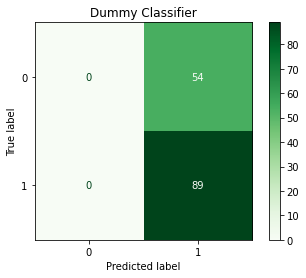

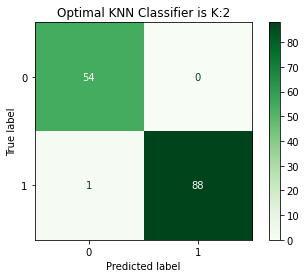

In [213]:
#Use sns.heatmap() to plot the confusion matrices from above.  
#Set annot = True to see the numbers, and change the colormap to something easier to read
#with cmap='Greens' (or whatever color map you like)
my_colors = 'Greens'
normVal = None
my_classifier = DummyClassifier()
m_title = "Dummy Classifier"
kn_mets = calculate_model(X_train, X_test, y_train, y_test, my_classifier, m_title, True, my_colors, normVal)

my_classifier = KNeighborsClassifier(n_neighbors=max_knn_counter)
m_title = "Optimal KNN Classifier is K:" + str(max_knn_counter)
kn_mets = calculate_model(X_train, X_test, y_train, y_test, my_classifier, m_title, True, my_colors, normVal)

We see the false positives predictions (top right) and false negative predictions (bottom left) that our model made.  However, the bottom left is out of 89 total and the top right is out of 54 total.  We can see the normalized ratios of true and false predictions by normalizing along the 'true' or 'pred' axes in the confusion_matrix() function.  

To normalize along the 'true' axis, we set `confusion_matrix(y_test, y_prediction, normalize = 'true')`.  

Notice that it is the string 'true' NOT the boolean value: `True`

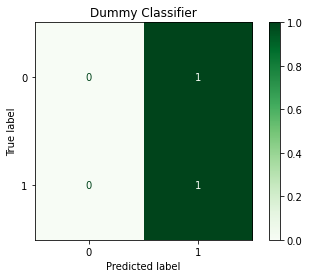

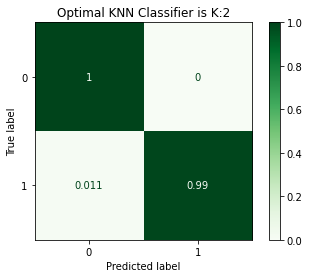

In [214]:
#Recreate the confusion matrix above, but with the values normalized along the 'true' axis.
normVal = 'true'
my_classifier = DummyClassifier()
m_title = "Dummy Classifier"
kn_mets = calculate_model(X_train, X_test, y_train, y_test, my_classifier, m_title, True, my_colors, normVal)

my_classifier = KNeighborsClassifier(n_neighbors=max_knn_counter)
m_title = "Optimal KNN Classifier is K:" + str(max_knn_counter)
kn_mets = calculate_model(X_train, X_test, y_train, y_test, my_classifier, m_title, True, my_colors, normVal)

We can now see that our KNN model successfully classified 99% of the samples in our test set that were malignant, class 1, and 89% of the samples in our test set that were benign, class 0.

Another quick way to check the accuracy, recall, and precision of a model on a test set is with `classification_report()`, which runs several metrics on both classes simultaneously.

In [215]:
#Use classifiction_report() to print a report of several metrics for all classes at once
#for both models
print("Classification report for Dummy Classifier:\n ", dy_mets['my_class_report'])

print("Classification report for KNN Classifier:\n ", kn_mets['my_class_report'])

Classification report for Dummy Classifier:
                precision    recall  f1-score   support

           0       1.00      0.00      0.00        54
           1       0.62      1.00      0.77        89

    accuracy                           0.62       143
   macro avg       0.81      0.50      0.38       143
weighted avg       0.76      0.62      0.48       143

Classification report for KNN Classifier:
                precision    recall  f1-score   support

           0       0.98      1.00      0.99        54
           1       1.00      0.99      0.99        89

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143



You'll notice that each class has a different recall and precision.  f1-score, by the way, is the harmonic mean of the precision and recall.  

classification_report also tells us the averages of the precisions, means, and f1-scores.  'support' is how many samples there are of each class.

# Multi-class Metrics

Precision, recall, and accuracy also extend to cases when we have more than 2 possible classes.  However, in order to know how to calculate precision and recall we have to decide which class is our positive class.  We also become interested in the most complex patterns of errors that can occur.  

For examples, suppose we have a problem with 3 possbile classes.  We might ask: 

When our model misclassifies class 1 samples, is it more often classifying them as class 0, or class 2?  This my help us understand why it is making that kind of mistake and how we can improve performance.

This is where confusion matrices become even more useful in understanding how our model is behaving.

# Summary

Accuracy, precision, and recall all are metrics that give us different insights into how our model is performing in making predictions.  No one of them alone tells us everything, and different metrics are more or less important depending on our business problem.

However, we need to measure all three to make sure our model is making useful predictions.  Two ways to do this quickly are with a confusion matrix and a classification report.